This is a general page for testing differnt types of GPyTorch Model

Custom GP model with noise (as a template example of simplest custom model)

This one could be useful to illustrate how to add confidence bound in the plots

Iter 1/100 - Loss: 3.078855514526367
Iter 11/100 - Loss: 1.9717966318130493
Iter 21/100 - Loss: 1.71285080909729
Iter 31/100 - Loss: 1.6187007427215576
Iter 41/100 - Loss: 1.5633478164672852
Iter 51/100 - Loss: 1.5184382200241089
Iter 61/100 - Loss: 1.4958021640777588
Iter 71/100 - Loss: 1.4945569038391113
Iter 81/100 - Loss: 1.4927973747253418
Iter 91/100 - Loss: 1.4926453828811646
Mean predictions: tensor([1.6084, 2.5340, 3.5343])
Confidence region: tensor([0.8906, 1.8222, 2.8165]) to tensor([2.3262, 3.2457, 4.2521])


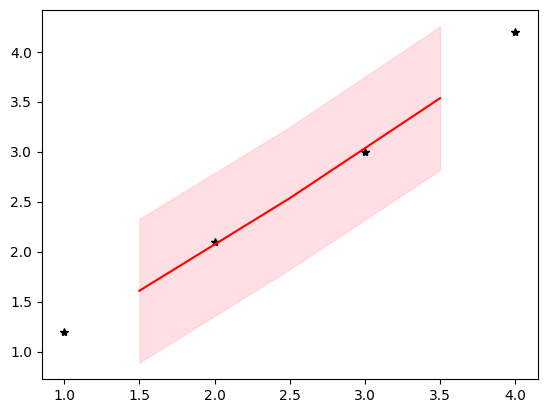

In [10]:
# Basic Gaussian Process Regression with GPyTorch NOISE!!!!
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Define the model class
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()
        
    def forward(self, x):
        # Define the GP forward pass
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

# Training data
train_x = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float32)
train_y = torch.tensor([1.2, 2.1, 3.0, 4.2], dtype=torch.float32)
train_y_noisy = train_y + torch.normal(0, 0.1, size=train_y.shape)  # Add noise

# Likelihood models the observation noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialize the model
model = GPModel(train_x, train_y_noisy, likelihood)

# Set the model into training mode
model.train()
likelihood.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  
], lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y_noisy)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f'Iter {i + 1}/100 - Loss: {loss.item()}')

# After training, set the model into evaluation mode
model.eval()
likelihood.eval()

# Make predictions on test data
test_x = torch.tensor([[1.5], [2.5], [3.5]], dtype=torch.float32)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = model(test_x)
    mean = pred.mean
    lower, upper = pred.confidence_region()

# Print results
print(f'Mean predictions: {mean}')
print(f'Confidence region: {lower} to {upper}')

# Plot results
plt.plot(train_x.numpy(), train_y.numpy(), 'k*')
plt.plot(test_x.numpy(), mean.numpy(), 'r')
plt.fill_between(test_x.numpy().flatten(), lower.numpy().flatten(), upper.numpy().flatten(), color='pink', alpha=0.5)
plt.show()


The following sections is a tutorial on gpytorch hyperparameters from the documents

In [9]:
# Understanding gpytorch hyperparameters (uses import from prev cell)
import gpytorch
import torch
import math

train_x = torch.linspace(0, 1, 100) # 100 points between 0 and 1
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2 # Noisy sine wave



class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#initialize likelihood and model
likelihood  = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [10]:
# Let's see what the parameters of this model are (These should be 0s since we haven't trained yet)

for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.raw_constant                   value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [26]:
#actual learned parameters of the model are things like noise and lengthscale, which must be positive 
# let's look at the parameter raw_outputscale
raw_outputscale = model.covar_module.raw_outputscale
print('raw outputscale, ', raw_outputscale)

# How can we look at the constraints ( as we want to make sure they are positive)
# three different ways

#1
print('\nraw_outputscale_constraint1', model.covar_module.raw_outputscale_constraint)
#2
print('\nprinting all model constraints:')
for constraint_name, constraint in model.named_constraints():
    print(f'Constraint name: {constraint_name:55} value = {constraint}')
#3
print('\ngetting raw outputscale constraint from model.covar_module...')
print(model.covar_module.constraint_for_parameter_name('raw_outputscale')) # this is the same as the first one


raw outputscale,  Parameter containing:
tensor(0., requires_grad=True)

raw_outputscale_constraint1 Positive()

printing all model constraints:
Constraint name: likelihood.noise_covar.raw_noise_constraint             value = GreaterThan(1.000E-04)
Constraint name: covar_module.raw_outputscale_constraint                 value = Positive()
Constraint name: covar_module.base_kernel.raw_lengthscale_constraint     value = Positive()

getting raw outputscale constraint from model.covar_module...
Positive()


In [31]:
# These constraints define 'transform' and 'inverse_transform', which turns raw parameters
# into real ones. For a positive constraint, we expect the transformed values to always be positive
raw_outputscale = model.covar_module.raw_outputscale
constraint = model.covar_module.raw_outputscale_constraint

print('Transformed ouputscale', constraint.transform(raw_outputscale))
print(constraint.inverse_transform(constraint.transform(raw_outputscale))) # should be same since trans than intrans
print(torch.equal(constraint.inverse_transform(constraint.transform(raw_outputscale)), raw_outputscale)) # returns True

print('Transform a bunch of negative tensors: ', constraint.transform(torch.tensor([-1.0, -2.0, -3.0])))

Transformed ouputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)
tensor(0., grad_fn=<AddBackward0>)
True
Transform a bunch of negative tensors:  tensor([0.3133, 0.1269, 0.0486])


In [36]:
# obviously, raw parameter values are difficult to work with. Humans understand things like noise variance = 0.01
# but we struggle to understand what raw_noise = -2.791 might mean. 
# all gpytorch modules that define raw parameters define convenience getters and setters for dealing with
# transformed values directly.

#reset model
model = ExactGPModel(train_x, train_y, likelihood)
#getting
print('Actual outputscale: ', model.covar_module.outputscale)
#setting
model.covar_module.outputscale = 2.
print('Actual outputscale: ', model.covar_module.outputscale)

#reset model
model = ExactGPModel(train_x, train_y, likelihood)
# these are shortcuts to do it the long way which would look like this 
raw_outputscale = model.covar_module.raw_outputscale
constraint = model.covar_module.raw_outputscale_constraint
outputscale = constraint.transform(raw_outputscale)
print('outputscale', outputscale)

model.covar_module.raw_outputscale.data.fill_(constraint.inverse_transform(torch.tensor(2.0)))
raw_outputscale = model.covar_module.raw_outputscale
outputscale = constraint.transform(raw_outputscale)
print('outputscale', outputscale)

Actual outputscale:  tensor(0.6931, grad_fn=<SoftplusBackward0>)
Actual outputscale:  tensor(2., grad_fn=<SoftplusBackward0>)
outputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)
outputscale tensor(3., grad_fn=<SoftplusBackward0>)


In [37]:
# noise
print('Actual noise value: ', likelihood.noise)
print('Noise constraint: ', likelihood.noise_covar.raw_noise_constraint)

Actual noise value:  tensor([0.6932], grad_fn=<AddBackward0>)
Noise constraint:  GreaterThan(1.000E-04)


In [45]:
# noise can be set when created
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.1))
print('noise constraint: ', likelihood.noise_covar.raw_noise_constraint)

# or changed after module is created
likelihood.noise_covar.register_constraint('raw_noise', gpytorch.constraints.Positive())
print('noise constraint: ', likelihood.noise_covar.raw_noise_constraint)


noise constraint:  GreaterThan(1.000E-01)
noise constraint:  Positive()


In [47]:
# priors can also be or created
# registers a prior on the sqrt of the noise parameter (e.g. a prior for the nosie SD instead of var)
likelihood.noise_covar.register_prior(
    'noise_std_prior',
    gpytorch.priors.NormalPrior(0,1), # noraml distribution with prior mean 0 and std 1
    lambda module: module.noise.sqrt() # this is the bit that modifies the prior (by sqrt'ing the noise parameter)
)

# Create a Gaussianlikelihood with a normal prior for the noise
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1e-3),
    noise_prior = gpytorch.priors.NormalPrior(0,1)
)

In [ ]:
# Let's follow the tutorial and make a custom gp using Exact GP
# this provides an example of the above all put together to customize a the ExactGP model

class FancyGPWithPriors(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(FancyGPWithPriors, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        lengthscale_prior = gpytorch.priors.GammaPrior(3.0, 6.0) # gamma prior with shape 3 and scale 6
        outputscale_prior = gpytorch.priors.GammaPrior(2.0, 0.15) # gamma prior with shape 2 and scale 0.15

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=lengthscale_prior,
            ),
            outputscale_prior = outputscale_prior
        )

        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1e-2)
)

model = FancyGPWithPriors(train_x, train_y, likelihood)

In [51]:
# and initializing hyperparameters in one call 
# for convenience, gpytorch modules allow to update a full dictionary of parametes on submodules. for example:

hypers = {
    'likelihood.noise_covar.noise': torch.tensor(1.),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5),
    'covar_module.outputscale': torch.tensor(2.)
}

model.initialize(**hypers) # this will set the values of the parameters in the model to the values in the hypers dictionary
print(
    model.likelihood.noise_covar.noise.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item()
)

1.0000001192092896 0.5 2.0


How to save and load models in gpytorch

In [59]:
#this is exact same from the first cell of the hyperparameters section

train_x = torch.linspace(0, 1, 100) # 100 points between 0 and 1
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2 # Noisy sine wave



class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#initialize likelihood and model
likelihood  = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [60]:
# let's change default hyperparameters to demonstrate how this works
model.covar_module.outputscale = 2.3
model.covar_module.base_kernel.lengthscale = 6.2

In [61]:
# this will call the full state of the gpytorch model
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(0.)),
             ('covar_module.raw_outputscale', tensor(2.1944)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[6.1980]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [62]:
# And this will save that
torch.save(model.state_dict(), 'model_state.pth')

In [64]:
# let's load this state (with a demonstration to show it makes a difference)
state_dict = torch.load('model_state.pth')
model=ExactGPModel(train_x, train_y, likelihood) # reinitialize a new model

before = model.state_dict()
print(before)


model.load_state_dict(state_dict)
after = model.state_dict()

print(after)

OrderedDict({'likelihood.noise_covar.raw_noise': tensor([0.]), 'likelihood.noise_covar.raw_noise_constraint.lower_bound': tensor(1.0000e-04), 'likelihood.noise_covar.raw_noise_constraint.upper_bound': tensor(inf), 'mean_module.raw_constant': tensor(0.), 'covar_module.raw_outputscale': tensor(0.), 'covar_module.base_kernel.raw_lengthscale': tensor([[0.]]), 'covar_module.base_kernel.raw_lengthscale_constraint.lower_bound': tensor(0.), 'covar_module.base_kernel.raw_lengthscale_constraint.upper_bound': tensor(inf), 'covar_module.raw_outputscale_constraint.lower_bound': tensor(0.), 'covar_module.raw_outputscale_constraint.upper_bound': tensor(inf)})
OrderedDict({'likelihood.noise_covar.raw_noise': tensor([0.]), 'likelihood.noise_covar.raw_noise_constraint.lower_bound': tensor(1.0000e-04), 'likelihood.noise_covar.raw_noise_constraint.upper_bound': tensor(inf), 'mean_module.raw_constant': tensor(0.), 'covar_module.raw_outputscale': tensor(2.1944), 'covar_module.base_kernel.raw_lengthscale': t

In [ ]:
# an advanced example with a DKL (Deep Kernel Learning model)
# this model type allows the NN to transform raw input into a better space for GP to operate on (similar to preprocessing)
# basically the GPR is operating over the NN output
# the whole model can be optimized using this gramework under marginal log likelihood

class GPwithNNFeatureExtractor(gpytorch.models.ExactGP): # custom GP model 
    def __init__(self, train_x, train_y, likelihood):
        super(GPwithNNFeatureExtractor, self).__init__(train_x, train_y, likelihood) # this and prev line calls the parent class with training data and likelihood = Gaussian noise model
        self.mean_module = gpytorch.means.ConstantMean() # assumes the output has a constant mean (learnable scalar)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # ScaleKernel wraps the RBF kernel with a scalar multiplier

        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Linear(1, 2),
            torch.nn.BatchNorm1d(2),
            torch.nn.ReLU(),
            torch.nn.Linear(2, 2),
            torch.nn.BatchNorm1d(2),
            torch.nn.ReLU(),
        ) # simple 2-layer feed-forward (1 input, 2 transformed features, with Batch norm to stabilize training, and ReLU adding non-linearity)

    def forward(self, x): # even though we define the nn architecture last, we see below it is executed first before being fed into the GPR
        x = self.feature_extractor(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
lieklihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPwithNNFeatureExtractor(train_x, train_y, likelihood)

In [ ]:
model.state_dict() # this will show the orderdictionary which is much more complex

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(0.)),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf)),
             ('feature_extractor.0.weight',
              tensor([[0.8996],
                      [0.2294]])),
             ('f

In [70]:
# however saving and loading will work exactly the same
torch.save(model.state_dict(), 'my_gp_with_nn_model.pth')
state_dict = torch.load('my_gp_with_nn_model.pth')
model = GPwithNNFeatureExtractor(train_x, train_y, likelihood)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [71]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(0.)),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf)),
             ('feature_extractor.0.weight',
              tensor([[0.8996],
                      [0.2294]])),
             ('f

The following is for Kernels: Sum and Products

In [ ]:
# Base kernels
rbf_kernel_1 = gpytorch.kernels.RBFKernel()
cos_kernel_1 = gpytorch.kernels.CosineKernel()
rbf_kernel_2 = gpytorch.kernels.RBFKernel()
cos_kernel_2 = gpytorch.kernels.CosineKernel()

# Manual Implementation 
spectral_mixture_kernel_1 = (rbf_kernel_1 * cos_kernel_1) + (rbf_kernel_2 * cos_kernel_2)
# of course, it probably makes more sense to use the spectral mixture kernel provided in gpytorch
spectral_mixture_kernel_2 = gpytorch.kernels.SpectralMixtureKernel

In [78]:
# efficient summation of univariate kernels
d=3

batch_univariate_rbf_kernel = gpytorch.kernels.RBFKernel(
    batch_shape = torch.Size([d]), # A batch of d...
    ard_num_dims=1 # ...univariate kernels
)

#including batch_shape ensure that the lengthscale parameter of batch_univariate_rbf_kernel is a d x 1 x 1 tensor
# meaning each univariate kernel will have its own lengthscale (you can have them all have the same lengthscale by omitting the batch_shape argument)



#to compute the univariate kernel matrices, we need to feed the appropriate dimensions of X into each of the component
# kernels. We accomplish this by reshaping the 'n x d' matrix representing X into a batch of d x (n x 1) 
n = 10

X = torch.randn(n, d) # some random data in a n x d matrix
batched_dimensions_of_X = X.mT.unsqueeze(-1) # now a 'd x n x 1' tensor

# we then feed the batches of univariate data into the batched kernel object to get our batch of univariate kernel matrices
univariate_rbf_covars = batch_univariate_rbf_kernel(batched_dimensions_of_X)
univariate_rbf_covars.shape # d x n x n

# finally computing the sum over the batch (sum of univariate kernels)
additive_covar = univariate_rbf_covars.sum(dim=-3) # this could just be dim = 0 or no argument for same results
additive_covar.shape # n x n

torch.Size([10, 10])

In [81]:
# the followin is to demonstrate faster processes on GPU, which of course doesn't make a difference on my computer
from torch. utils import benchmark

d = 10
n = 500
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X = torch.randn(n, d, device=device)

naive_additive_kernel = (
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[0]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[1]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[2]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[3]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[4]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[5]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[6]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[7]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[8]) +
    gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=[9])
).to(device=device)

with gpytorch.settings.lazily_evaluate_kernels(False):
    print(benchmark.Timer(
        stmt="naive_additive_kernel(X)",
        globals={"naive_additive_kernel": naive_additive_kernel, "X": X}
    ).timeit(100))

# using the variable (same as above example) the code below should be significantly faster on GPU
batch_univariate_rbf_kernel = gpytorch.kernels.RBFKernel(
    batch_shape=torch.Size([d]), ard_num_dims=1,
).to(device=device)

with gpytorch.settings.lazily_evaluate_kernels(False):
    print(benchmark.Timer(
        stmt="batch_univariate_rbf_kernel(X.mT.unsqueeze(-1)).sum(dim=-3)",
        globals={"batch_univariate_rbf_kernel": batch_univariate_rbf_kernel, "X": X}
    ).timeit(100))

naive_additive_kernel(X)
  4.52 ms
  1 measurement, 100 runs , 1 thread
batch_univariate_rbf_kernel(X.mT.unsqueeze(-1)).sum(dim=-3)
  5.84 ms
  1 measurement, 100 runs , 1 thread


In [84]:
# a full example using GP wit additive kernels

class AdditiveKernelGP(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, d):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        super().__init__(X_train, y_train, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape = torch.Size([d]), 
                                       ard_num_dims = 1)
        )

    def forward(self, X):
        mean = self.mean_module(X)
        batched_dimensions_of_X = X.mT.unsqueeze(-1) # now a d x n x 1 tensor
        covar = self.covar_module(batched_dimensions_of_X).sum(dim=-3)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

I'll just add a standard base model here, which should be sufficient for general scientific purposes

In [94]:
import gpytorch
import torch

torch.manual_seed(42)

# Example toy data: 10 samples with some noise added to the target values
train_x = torch.randn(10, 1)
train_y = torch.randn(10) + 0.1 * torch.randn(10)  # Add some noise

# Define the Gaussian likelihood (with noise)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Define the GP model (Exact GP)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the model
model = ExactGPModel(train_x, train_y, likelihood)

# Define the marginal log-likelihood (MLL) function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Optimizer for training the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Training loop
for i in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)  # Minimize the negative log-likelihood
    print(f"Iteration {i}, Loss: {loss.item()}")  # .item() converts to a scalar value for printing
    loss.backward()
    optimizer.step()

# After training, you can check the learned noise level
print("Learned noise level:", likelihood.noise.item())


Iteration 0, Loss: 1.5816723108291626
Iteration 1, Loss: 1.5640580654144287
Iteration 2, Loss: 1.552570104598999
Iteration 3, Loss: 1.5462846755981445
Iteration 4, Loss: 1.5437391996383667
Iteration 5, Loss: 1.5432567596435547
Iteration 6, Loss: 1.5436580181121826
Iteration 7, Loss: 1.5443774461746216
Iteration 8, Loss: 1.5451809167861938
Iteration 9, Loss: 1.5459697246551514
Iteration 10, Loss: 1.5466740131378174
Iteration 11, Loss: 1.5471903085708618
Iteration 12, Loss: 1.5473798513412476
Iteration 13, Loss: 1.5471376180648804
Iteration 14, Loss: 1.5464680194854736
Iteration 15, Loss: 1.5454977750778198
Iteration 16, Loss: 1.5444262027740479
Iteration 17, Loss: 1.543452262878418
Iteration 18, Loss: 1.5427170991897583
Iteration 19, Loss: 1.5422743558883667
Iteration 20, Loss: 1.542096495628357
Iteration 21, Loss: 1.5421099662780762
Iteration 22, Loss: 1.5422348976135254
Iteration 23, Loss: 1.5424083471298218
Iteration 24, Loss: 1.5425866842269897
Iteration 25, Loss: 1.542739987373352
